__Author:__ Bram Van de Sande

__Date:__ 9 FEB 2018

__Outline:__ Compare the results of the different implementation of the SCENIC pipeline. The example used in the tutorial is used in this comparison (https://github.com/aertslab/SCENIC). 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyscenic.utils import save_to_yaml
%matplotlib inline

### Phase Ib: Derive potential regulomes from these co-expression modules

#### Check implementation of `modules_from_genie3`

Start from the GENIE3 output and check if derived co-expression modules are similar.

In [2]:
adjacencies = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.5_GENIE3_linkList.txt',
                          usecols=['TF', 'Target', 'weight'])
adjacencies.columns = ["TF", "target", "importance"]

Creation of the modules.

In [5]:
df_modules = adjacencies[adjacencies['importance'] > 0.001]
df_modules['method'] = 'w001'

df_tmp = adjacencies[adjacencies['importance'] > 0.005].copy()
df_tmp['method'] = 'w005'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='TF').apply(lambda grp: grp.nlargest(50, "importance")).copy()
df_tmp['method'] = 'top50'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(5, "importance")).copy()
df_tmp['method'] = 'top5perTarget'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(10, "importance")).copy()
df_tmp['method'] = 'top10perTarget'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(50, "importance")).copy()
df_tmp['method'] = 'top50perTarget'
df_modules = df_modules.append(df_tmp)
df_modules.index = range(len(df_modules))

In [6]:
len(df_modules)

4363616

In [7]:
df_modules.method.value_counts()

w001              3261351
top50perTarget     604300
w005               266475
top10perTarget     120860
top5perTarget       60430
top50               50200
Name: method, dtype: int64

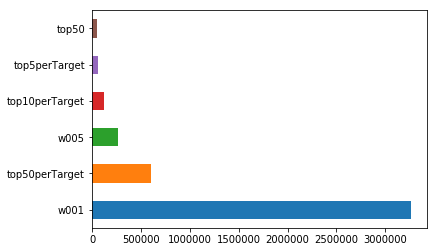

In [8]:
df_modules.method.value_counts().plot.barh()

In [9]:
df_modules[df_modules['TF'] == df_modules['target']]

,TF,target,importance,method


Compare the results with the modules derived by the R pipeline.

In [10]:
r_modules = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.6_tfModules.txt',
                          usecols=['Target', 'TF', 'method'])
r_modules.columns = ['target', 'TF', 'method']

In [12]:
len(r_modules)

4363616

In [13]:
r_modules.method.value_counts()

w001              3261351
top50perTarget     604300
w005               266475
top10perTarget     120860
top5perTarget       60430
top50               50200
Name: method, dtype: int64

Exact comparison.

In [14]:
COLUMN_NAMES = ['TF', 'target', 'method']
df_modules = df_modules[COLUMN_NAMES].sort_values(by=COLUMN_NAMES).reset_index()
del df_modules['index']

In [15]:
r_modules = r_modules.sort_values(by=COLUMN_NAMES).reset_index()
del r_modules['index']
r_modules = r_modules[COLUMN_NAMES]

In [16]:
r_modules.equals(df_modules)

True

### Phase II: Prune modules for targets with cis regulatory footprints (aka RcisTarget)

Testing of RcisTarget should start from exactly the same baseline. Modules for the python pipeline will therefore be created from the link lists with correlation information used in the R scripts.

In [2]:
from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
import os
from collections import defaultdict
from pyscenic.genesig import Regulome
from operator import concat
from functools import reduce
from pyscenic.regulome import derive_regulomes

In [3]:
DATABASE_FOLDER = "/Users/bramvandesande/Projects/lcb/databases/"
DATABASE_FNAME_500bp = os.path.join(DATABASE_FOLDER, "mm9-500bp-upstream-10species.mc9nr.feather")
DATABASE_FNAME_10kbp = os.path.join(DATABASE_FOLDER, "mm9-tss-centered-10kb-10species.mc9nr.feather")

RESOURCES_FOLDER="/Users/bramvandesande/Projects/lcb/resources"
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl")

#### Create modules from R datafile

In [4]:
r_adjacencies = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.7_tfModules_withCorr.txt',
                         usecols=['Target', 'TF', 'method', 'corr'])
r_adjacencies.head()

,Target,TF,method,corr
0,Slc27a3,1810024B03Rik,w001,0
1,Ankrd39,1810024B03Rik,w001,1
2,Tbc1d25,1810024B03Rik,w001,0
3,Mak,1810024B03Rik,w001,1
4,Tmem86b,1810024B03Rik,w001,1


1. Remove genes in a module that are not part of the database rankings.
2. Remove modules with number of genes < 20.
3. Add own TF to its own module.
4. Only look at TF-target that have an activiting function.

In [5]:
genes_in_db = RankingDatabase(DATABASE_FNAME_500bp, name="500bp", nomenclature="MGI").geneset
r_adjacencies = r_adjacencies[r_adjacencies['corr'] > 0]
method2modules = defaultdict(list)
for (tf, method), df_grp in r_adjacencies.groupby(by=['TF', 'method']):
    targets = set(df_grp['Target'].values)
    if len(targets) < 20:
        continue
    targets.add(tf)
    regulome = Regulome(name="{} - {}".format(tf, method), nomenclature="MGI", 
                        score=0.0, context=frozenset([method]),
                        transcription_factor=tf, gene2weights=targets.intersection(genes_in_db))
    method2modules[method].append(regulome)

In [6]:
for method, modules in method2modules.items():
    print(method, "-", len(modules))

top50 - 974
top50perTarget - 976
w001 - 1004
w005 - 612
top10perTarget - 486
top5perTarget - 259


In [7]:
modules = reduce(concat, method2modules.values())
len(modules)

4311

In [8]:
save_to_yaml(modules, os.path.join(RESOURCES_FOLDER, "modules_zeisel_2015.yaml"))

#### Create dataframe with enriched and TF-annotated motifs + leading edges

In [9]:
rnkdbs = [RankingDatabase(fname, name, "MGI") for fname, name in zip([DATABASE_FNAME_500bp, DATABASE_FNAME_10kbp], ['500bp', '10kbp'])]
rnkdbs

[FeatherRankingDatabase(name="500bp",nomenclature=MGI),
 FeatherRankingDatabase(name="10kbp",nomenclature=MGI)]

In [10]:
df = derive_regulomes(rnkdbs, modules, 
                      MOTIF_ANNOTATIONS_FNAME, 
                      rank_threshold=5000, auc_threshold=0.01, nes_threshold=3.0,
                      output="df",
                      client_or_address="custom_multiprocessing", num_workers=6)

Using 6 workers.
Worker 10kbp(3): database loaded in memory.
Worker 10kbp(1): database loaded in memory.
Worker 10kbp(2): database loaded in memory.
Worker 10kbp(1): motif annotations loaded in memory.
Worker 10kbp(2): motif annotations loaded in memory.
Worker 10kbp(3): motif annotations loaded in memory.
Worker 500bp(2): database loaded in memory.
Worker 500bp(1): database loaded in memory.
Worker 500bp(3): database loaded in memory.
Worker 500bp(2): motif annotations loaded in memory.
Worker 500bp(3): motif annotations loaded in memory.
Worker 500bp(1): motif annotations loaded in memory.
Worker 500bp(3): All regulomes derived.
Worker 500bp(1): All regulomes derived.
Worker 500bp(1): Done.
Worker 10kbp(3): All regulomes derived.
Worker 500bp(2): All regulomes derived.
Worker 500bp(2): Done.
Worker 500bp(3): Done.
Worker 10kbp(1): All regulomes derived.
Worker 10kbp(1): Done.
Worker 10kbp(2): All regulomes derived.
Worker 10kbp(2): Done.
Worker 10kbp(3): Done.


Potential causes of differences:
1. 0-based rankings (python) versus 1-based rankings (R SCENIC version)? This has an effect on the interpretation of rank_cutoff. With 0-based the rank_cutoff is included while in 1-based systems this is not the cause. Both are correct calculations but just a difference in interpretation of the parameter. The normalization factor (maxAUC) should be corrected though.
```
aucThreshold <- round(aucMaxRank)
maxAUC <- aucThreshold * nrow(gSetRanks)
```
(According to this code snippet the maxAUC is calculated to take the aucThreshold into account while this is not the case for the current R implementation of the AUC calculation + 1-based rankings)
```
.auc <- function(oneRanking, aucThreshold, maxAUC)
{
  x <- oneRanking
  x <- sort(x[x<aucThreshold])

  y <- seq_along(x)
  sum(diff(c(x, aucThreshold)) * y)/maxAUC
}
```
2. NES threshold (3.0). Exactly the same for both pipeline.
3. Digits for truncation of NES and AUC values (3). Is available in the R version of the pipeline. This should have no effect on the calculations as this is only used for creating the final results table.
4. Rank threshold (5000). Is exactly the same. Can only have an effect on the LE calculation. Has no effect on AUC calculations.
5. AUC fraction (0.01). Is used to calculate the rank cutoff. Is the same between both pipelines.
6. Minimum orthologous identity and maximum motif similarity FDR: effect can be assessed in the results table from the python pipeline.

In [12]:
len(df)

22804

In [13]:
df.head()

Enrichment            \
                                            AUC       NES   
TF     MotifID                                              
Acaa1b transfac_pro__M01543            0.076742  4.846509   
       transfac_pro__M04671            0.076380  4.821018   
Ar     homer__CCAGGAACAG_AR-halfsite   0.050721  7.485099   
Arid3a transfac_pro__M04727            0.033484  3.115786   
       cisbp__M4455                    0.035068  3.291999   

                                                            \
                                     MotifSimilarityQvalue   
TF     MotifID                                               
Acaa1b transfac_pro__M01543                       0.000000   
       transfac_pro__M04671                       0.000000   
Ar     homer__CCAGGAACAG_AR-halfsite              0.000000   
Arid3a transfac_pro__M04727                       0.000255   
       cisbp__M4455                               0.000009   

                                                          \
                                     OrthologousIdentity   
TF     MotifID                                             
Acaa1b transfac_pro__M01543                     0.517986   
       transfac_pro__M04671                     0.517986   
Ar     homer__CCAGGAACAG_AR-halfsite            0.877642   
Arid3a transfac_pro__M04727                     0.798669   
       cisbp__M4455                             0.798669   

                                                                                         \
                                                                             Annotation   
TF     MotifID                                                                            
Acaa1b transfac_pro__M01543           motif similar to transfac_pro__M04671 ('F$POT1...   
       transfac_pro__M04671           motif is annotated for orthologous gene YIL160...   
Ar     homer__CCAGGAACAG_AR-halfsite  gene is orthologous to ENSG00000169083 in H. s...   
Arid3a transfac_pro__M04727           gene is orthologous to ENSG00000116017 in H. s...   
       cisbp__M4455                   gene is orthologous to ENSG00000116017 in H. s...   

                                                      \
                                             Context   
TF     MotifID                                         
Acaa1b transfac_pro__M01543           (top50, 500bp)   
       transfac_pro__M04671           (top50, 500bp)   
Ar     homer__CCAGGAACAG_AR-halfsite  (top50, 500bp)   
Arid3a transfac_pro__M04727           (top50, 500bp)   
       cisbp__M4455                   (top50, 500bp)   

                                                                                         
                                                                            TargetGenes  
TF     MotifID                                                                           
Acaa1b transfac_pro__M01543           [(Col7a1, 105), (Lmna, 107), (Crh, 109), (Htr1...  
       transfac_pro__M04671           [(Col7a1, 101), (Lmna, 106), (Crh, 109), (Htr1...  
Ar     homer__CCAGGAACAG_AR-halfsite          [(Bmpr1b, 17), (Kcns1, 45), (Ptpru, 119)]  
Arid3a transfac_pro__M04727                                                 [(Sdk2, 6)]  
       cisbp__M4455                                     [(Hbegf, 30), (Tnfaip8l2, 102)]

There are far less regulomes when using the python pipeline.

In [21]:
df.index.get_level_values('TF').unique()

Index(['Acaa1b', 'Ar', 'Arid3a', 'Arid5b', 'Arx', 'Ascl1', 'Atf1', 'Atf2',
       'Atf3', 'Atf4',
       ...
       'Pou3f3', 'Sox12', 'Tia1', 'Gli3', 'Grhl1', 'Meis2', 'Myef2', 'Zfhx2',
       'Zfp672', 'Nr2f1'],
      dtype='object', name='TF', length=423)

In [22]:
df.index.get_level_values('TF').unique().values

array(['Acaa1b', 'Ar', 'Arid3a', 'Arid5b', 'Arx', 'Ascl1', 'Atf1', 'Atf2',
       'Atf3', 'Atf4', 'Atf5', 'Atf6', 'Bach2', 'Bbx', 'Bcl11a', 'Bcl6b',
       'Bdp1', 'Bhlhe22', 'Bmyc', 'Brf1', 'Cbfb', 'Ccnt2', 'Cebpb',
       'Cebpg', 'Cenpb', 'Cic', 'Ckmt1', 'Clock', 'Cpsf4', 'Creb1',
       'Creb3', 'Creb3l1', 'Crebl2', 'Ctcf', 'Cux1', 'Dbx2', 'Ddit3',
       'Dlx1', 'Dlx2', 'Dlx5', 'Dmrta2', 'E2f1', 'E2f3', 'E2f4', 'E2f5',
       'E2f6', 'E4f1', 'Egr4', 'Elf1', 'Elk3', 'Elk4', 'Emx1', 'Ep300',
       'Esrra', 'Ets1', 'Ets2', 'Etv3', 'Etv4', 'Fli1', 'Fos', 'Fosb',
       'Fosl2', 'Foxc1', 'Foxj3', 'Foxk1', 'Foxo1', 'Foxp1', 'Foxp2',
       'Foxp4', 'Gabpb1', 'Gata2', 'Gtf2b', 'Hdac2', 'Hif1a', 'Hivep3',
       'Homez', 'Hsf1', 'Irf2', 'Irf3', 'Irf9', 'Jdp2', 'Jun', 'Junb',
       'Jund', 'Kdm5a', 'Klf16', 'Klf2', 'Lef1', 'Lhx6', 'Lmo2', 'Maf',
       'Maff', 'Mef2a', 'Mxd4', 'Myc', 'Neurod1', 'Neurod2', 'Nfatc1',
       'Nfatc2', 'Nfe2l1', 'Nfe2l2', 'Nfib', 'Nfic', 'Nkx2-2', 'Npas2',
 

Compare the top 5 results documented in the tutorial.

In [39]:
df[df.index.get_level_values('TF') == 'Rfx3'].sort_values(by=('Enrichment', 'NES'), ascending=False)

Enrichment            \
                                                    AUC       NES   
TF   MotifID                                                        
Rfx3 cisbp__M1524                              0.100987  9.571583   
     cisbp__M1539                              0.092349  8.696942   
     cisbp__M1533                              0.092349  8.696942   
     cisbp__M1528                              0.090498  8.509519   
     cisbp__M1524                              0.113414  8.292187   
     cisbp__M1525                              0.088235  8.280446   
     cisbp__M1529                              0.085253  7.978487   
     cisbp__M1537                              0.097796  7.751492   
     cisbp__M1536                              0.082991  7.749414   
     cisbp__M1537                              0.082991  7.749414   
     hocomoco__RFX1_HUMAN.H11MO.1.B            0.081551  7.603640   
     cisbp__M1524                              0.095898  7.590429   
     cisbp__M1529                              0.095752  7.578039   
     cisbp__M1539                              0.101445  7.354042   
     cisbp__M1533                              0.101445  7.354042   
     cisbp__M1535                              0.092687  7.317859   
     cisbp__M1528                              0.098672  7.136667   
     cisbp__M1534                              0.076923  7.135083   
     cisbp__M1530                              0.090060  7.094848   
     yetfasco__YLR176C_496                     0.076512  7.093433   
     cisbp__M1525                              0.095606  6.896410   
     cisbp__M1537                              0.068902  6.844587   
     cisbp__M1524                              0.076237  6.816300   
     hdpi__RFX3                                0.073632  6.801886   
     transfac_pro__M02789                      0.073221  6.760236   
     dbcorrdb__RFX5__ENCSR000EHY_1__m1         0.075415  6.736907   
     cisbp__M1539                              0.085681  6.723163   
     cisbp__M1528                              0.085681  6.723163   
     cisbp__M1532                              0.085535  6.710774   
     cisbp__M1524                              0.067565  6.700169   
...                                                 ...       ...   
     cisbp__M5780                              0.038804  3.203930   
     cisbp__M2309                              0.038804  3.203930   
     cisbp__M5775                              0.038667  3.190698   
     cisbp__M1539                              0.019337  3.188519   
     cisbp__M2309                              0.034862  3.167496   
     dbcorrdb__MXI1__ENCSR000EGZ_1__m1         0.010325  3.166793   
     transfac_pro__M07305                      0.011548  3.162506   
     hocomoco__RFX6_MOUSE.H11MO.1.C            0.043643  3.154985   
     taipale__RFX2_DBD_NGTTRCCATGGYAACN_repr   0.038256  3.151001   
     cisbp__M1524                              0.017287  3.132823   
     cisbp__M1530                              0.017287  3.132823   
     dbcorrdb__RFX5__ENCSR000ECF_1__m1         0.011491  3.127120   
     cisbp__M1535                              0.037982  3.124537   
     cisbp__M6077                              0.047292  3.109508   
     cisbp__M6451                              0.017113  3.086915   
     cisbp__M6451                              0.047000  3.086627   
     transfac_pro__M07882                      0.011416  3.080320   
     dbcorrdb__RFX5__ENCSR000EGO_1__m1         0.035651  3.072895   
     dbcorrdb__RFX5__ENCSR000EGO_1__m1         0.011395  3.066622   
     dbcorrdb__MXI1__ENCSR000EBR_1__m2         0.011393  3.065481   
     cisbp__M1529                              0.017017  3.061410   
     cisbp__M6075                              0.037296  3.058377   
     hocomoco__RFX1_HUMAN.H11MO.1.B            0.042476  3.055869   
     cisbp__M4575                              0.010186  3.053835   
     cisbp__M6452                          

Save to disk.

In [15]:
df.to_csv(os.path.join(RESOURCES_FOLDER, "regulomes_zeisel_2015.csv"))

In [10]:
#df = pd.read_csv(os.path.join(RESOURCES_FOLDER, "regulomes_zeisel_2015.csv"),
                 index_col=[0,1], header=[0,1], skipinitialspace=True)

Compare enriched motifs with results from R pipeline.

In [42]:
r_df = pd.read_csv(os.path.join(RESOURCES_FOLDER, "rscenic/2.4_motifEnrichment_selfMotifs.txt"))

In [51]:
r_df.sort_values(by='NES', ascending=False).sort_values(by=['highlightedTFs']).head(10)

,Unnamed: 0,motifDb,geneSet,motif,NES,AUC,highlightedTFs,TFinDB,TF_direct,TF_inferred
1,2,500bp,Acaa1b_top50,transfac_pro__M04671,4.28,0.0733,Acaa1b,**,Acaa1a; Acaa1b; Foxf1; Foxf2; Foxg1; Foxh1; Fo...,NaN
0,1,500bp,Acaa1b_top50,transfac_pro__M01543,4.39,0.0749,Acaa1b,**,Acaa1a; Acaa1b; Foxf1; Foxf2; Foxg1; Foxh1; Fo...,NaN
2,3,500bp,Ahr_w001,transfac_pro__M00778,3.22,0.0131,Ahr,**,Ahr,NaN
4,5,500bp,Ahr_w001,cisbp__M6139,3.08,0.0128,Ahr,**,Ahr,Arnt
5,6,500bp,Ahr_w001,transfac_pro__M00976,3.03,0.0127,Ahr,**,Ahr; Ahrr; Arnt; Arnt2; Hif1a,NaN
3,4,500bp,Ahr_w001,hocomoco__AHR_HUMAN.H10MO.B,3.12,0.0129,Ahr,**,Ahr,Arnt
6,7,500bp,Anxa11_top50,hdpi__ANXA11,3.15,0.0478,Anxa11,**,Anxa11,NaN
46,47,500bp,Ar_top50,homer__CCAGGAACAG_AR-halfsite,7.21,0.0537,Ar,**,Ar,NaN
5037,5038,10kbp,Ar_top50,cisbp__M5683,3.12,0.0322,Ar,**,Ar; Nr3c1; Nr3c2,NaN
5017,5018,10kbp,Arid3a_w001,tfdimers__MD00454,3.10,0.0151,Arid3a,**,Arid3a; Pax4,NaN


In [50]:
df.head().sort_values(by=[('Enrichment', 'NES')], ascending=False).sort_index(level=0).head(10)

Enrichment            \
                                            AUC       NES   
TF     MotifID                                              
Acaa1b transfac_pro__M01543            0.076742  4.846509   
       transfac_pro__M04671            0.076380  4.821018   
Ar     homer__CCAGGAACAG_AR-halfsite   0.050721  7.485099   
Arid3a cisbp__M4455                    0.035068  3.291999   
       transfac_pro__M04727            0.033484  3.115786   

                                                            \
                                     MotifSimilarityQvalue   
TF     MotifID                                               
Acaa1b transfac_pro__M01543                       0.000000   
       transfac_pro__M04671                       0.000000   
Ar     homer__CCAGGAACAG_AR-halfsite              0.000000   
Arid3a cisbp__M4455                               0.000009   
       transfac_pro__M04727                       0.000255   

                                                          \
                                     OrthologousIdentity   
TF     MotifID                                             
Acaa1b transfac_pro__M01543                     0.517986   
       transfac_pro__M04671                     0.517986   
Ar     homer__CCAGGAACAG_AR-halfsite            0.877642   
Arid3a cisbp__M4455                             0.798669   
       transfac_pro__M04727                     0.798669   

                                                                                         \
                                                                             Annotation   
TF     MotifID                                                                            
Acaa1b transfac_pro__M01543           motif similar to transfac_pro__M04671 ('F$POT1...   
       transfac_pro__M04671           motif is annotated for orthologous gene YIL160...   
Ar     homer__CCAGGAACAG_AR-halfsite  gene is orthologous to ENSG00000169083 in H. s...   
Arid3a cisbp__M4455                   gene is orthologous to ENSG00000116017 in H. s...   
       transfac_pro__M04727           gene is orthologous to ENSG00000116017 in H. s...   

                                                      \
                                             Context   
TF     MotifID                                         
Acaa1b transfac_pro__M01543           (top50, 500bp)   
       transfac_pro__M04671           (top50, 500bp)   
Ar     homer__CCAGGAACAG_AR-halfsite  (top50, 500bp)   
Arid3a cisbp__M4455                   (top50, 500bp)   
       transfac_pro__M04727           (top50, 500bp)   

                                                                                         
                                                                            TargetGenes  
TF     MotifID                                                                           
Acaa1b transfac_pro__M01543           [(Col7a1, 105), (Lmna, 107), (Crh, 109), (Htr1...  
       transfac_pro__M04671           [(Col7a1, 101), (Lmna, 106), (Crh, 109), (Htr1...  
Ar     homer__CCAGGAACAG_AR-halfsite          [(Bmpr1b, 17), (Kcns1, 45), (Ptpru, 119)]  
Arid3a cisbp__M4455                                     [(Hbegf, 30), (Tnfaip8l2, 102)]  
       transfac_pro__M04727                                                 [(Sdk2, 6)]

#### Creation of regulomes

In [23]:
from pyscenic.regulome import df2regulomes

In [24]:
regulomes = df2regulomes(df, "MGI")

In [26]:
len(regulomes)

1662

In [32]:
regulomes[0:3]

[Regulome(name='Acaa1b', nomenclature='MGI', gene2weights=<frozendict {'Col7a1': 1.0, 'Lmna': 1.0, 'Crh': 1.0, 'Htr1f': 1.0}>, transcription_factor='Acaa1b', context=frozenset({'top50', '500bp'}), score=2.510423682097521),
 Regulome(name='Acaa1b', nomenclature='MGI', gene2weights=<frozendict {'Lmna': 1.0, 'Crh': 1.0, 'Htr1f': 1.0, 'Rilpl2': 1.0, 'Phf21b': 1.0, 'Poli': 1.0, 'Mtfr1': 1.0}>, transcription_factor='Acaa1b', context=frozenset({'w005', '500bp'}), score=1.7872492343811763),
 Regulome(name='Ahr', nomenclature='MGI', gene2weights=<frozendict {'Crh': 1.0, 'Smad3': 1.0, 'Usp28': 1.0, 'Zbtb25': 1.0, 'Samd12': 1.0, 'Bhlhe41': 1.0, 'Maf': 1.0, 'Pou2f1': 1.0, 'St5': 1.0, 'Lin28b': 1.0, 'Maml3': 1.0, 'Zswim5': 1.0, 'Islr2': 1.0, 'Smoc2': 1.0, 'BC048403': 1.0, 'Slc25a36': 1.0, 'Erlin2': 1.0, 'Mir682': 1.0, 'Arrb2': 1.0, 'Aatf': 1.0, 'Apaf1': 1.0, 'Adrb2': 1.0, 'Dll3': 1.0, 'Kdm2b': 1.0, 'Tfdp2': 1.0, 'Nr4a2': 1.0, 'Phip': 1.0, 'Klf6': 1.0, 'Gjd2': 1.0, 'Dag1': 1.0, 'Igf2bp3': 1.0, '1190